In [9]:
import torch
from enformer_pytorch import Enformer
import read_sequence

In [2]:
model = Enformer.from_hparams(
    dim = 1536,
    depth = 11,
    heads = 8,
    output_heads = dict(human = 5313, mouse = 1643),
    target_length = 896,
)
    
seq = torch.randint(0, 5, (1, 196_608)) # for ACGTN, in that order (-1 for padding)
output = model(seq)

output['human'] # (1, 896, 5313)
output['mouse'] # (1, 896, 1643)

tensor([[[0.5933, 0.7416, 0.6510,  ..., 0.6486, 0.6856, 0.7062],
         [0.7219, 0.6173, 0.5954,  ..., 0.6557, 0.7302, 0.7331],
         [0.6747, 0.7979, 0.6998,  ..., 0.7885, 0.9170, 0.7123],
         ...,
         [0.6876, 0.6908, 0.7173,  ..., 0.7243, 0.7369, 0.7224],
         [0.6923, 0.7361, 0.6823,  ..., 0.5719, 0.7480, 0.6317],
         [0.6690, 0.7451, 0.7085,  ..., 0.6247, 0.7605, 0.6629]]],
       grad_fn=<SoftplusBackward0>)

In [3]:
len(seq[0])

def char_to_num(sequence):
    mapping = {'A': 0, 'C': 1, 'T': 2, 'G': 3, 'N': 4}
    return [mapping[nuc] for nuc in sequence.upper() if nuc in mapping]
    

In [6]:
from Bio import SeqIO
fasta_path = "/projects/ps-renlab2/sux002/DSC180/data/h38.fa" 
fasta_sequences = SeqIO.parse(open(fasta_path), 'fasta')
fasta_sequences
sequence_id = "1"
region_start = 10000 
region_end = 196608 + 10000
for record in fasta_sequences:
    if record.id == sequence_id:
        dna_sequence = str(record.seq[region_start:region_end])
        break
else:
    raise ValueError(f"Sequence ID {sequence_id} not found in the FASTA file.")


In [7]:
len(dna_sequence)

196608

In [10]:
sequence = read_sequence.char_to_num(dna_sequence)
sequence[:10]

[2, 0, 0, 1, 1, 1, 2, 0, 0, 1]

In [15]:
from enformer_pytorch import Enformer, seq_indices_to_one_hot
model = Enformer.from_hparams(
    dim = 1536,
    depth = 11,
    heads = 8,
    output_heads = dict(human = 5313, mouse = 1643),
    target_length = 896,
)

#seq = torch.randint(0, 5, (1, 196_608))
seq = torch.tensor(sequence)
one_hot = seq_indices_to_one_hot(seq)

output = model(one_hot)

output['human'] # (1, 896, 5313)
output['mouse'] # (1, 896, 1643)


tensor([[0.7180, 0.7428, 0.7404,  ..., 0.8574, 0.7515, 0.8009],
        [0.7746, 0.6439, 0.6679,  ..., 0.6412, 0.5629, 0.6809],
        [0.6955, 0.6252, 0.7269,  ..., 0.7209, 0.6728, 0.7452],
        ...,
        [0.8243, 0.7332, 0.7221,  ..., 0.7025, 0.7266, 0.6567],
        [0.7234, 0.6688, 0.8052,  ..., 0.7321, 0.6765, 0.7053],
        [0.6459, 0.7194, 0.7216,  ..., 0.8071, 0.6498, 0.6485]],
       grad_fn=<SoftplusBackward0>)

In [16]:
one_hot

tensor([[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]])

In [17]:
import torch
from enformer_pytorch import Enformer, seq_indices_to_one_hot

model = Enformer.from_hparams(
    dim = 1536,
    depth = 11,
    heads = 8,
    output_heads = dict(human = 5313, mouse = 1643),
    target_length = 896,
)

seq = torch.randint(0, 5, (1, 196_608))
one_hot = seq_indices_to_one_hot(seq)

output, embeddings = model(one_hot, return_embeddings = True)

embeddings # (1, 896, 3072)

tensor([[[-0.1170,  0.2627,  0.3184,  ...,  0.0029,  0.2671, -0.0637],
         [-0.0791, -0.1500, -0.0817,  ...,  0.1851, -0.0588, -0.0349],
         [-0.0502, -0.0188,  0.2616,  ..., -0.1581, -0.1328, -0.0353],
         ...,
         [-0.1591,  0.0781,  0.0102,  ...,  0.0416,  0.3931, -0.1373],
         [ 0.1392,  0.1800,  0.5444,  ..., -0.0191, -0.1445, -0.0182],
         [-0.0302,  0.4976,  0.1551,  ..., -0.1372, -0.0693,  0.2669]]],
       grad_fn=<MulBackward0>)

In [16]:
len(seq[0])

196608

In [17]:
import torch
from enformer_pytorch import Enformer, seq_indices_to_one_hot

model = Enformer.from_hparams(
    dim = 1536,
    depth = 11,
    heads = 8,
    output_heads = dict(human = 5313, mouse = 1643),
    target_length = 200,
).cuda()

seq = torch.randint(0, 5, (196_608 // 2,)).cuda()
target = torch.randn(200, 5313).cuda()

loss = model(
    seq,
    head = 'human',
    target = target
)

loss.backward()

# after much training

corr_coef = model(
    seq,
    head = 'human',
    target = target,
    return_corr_coef = True
)

corr_coef # pearson R, used as a metric in the paper

tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward1>)

In [19]:
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

model = Enformer.from_hparams(
    dim = 1536,
    depth = 11,
    heads = 8,
    output_heads = dict(human = 5313, mouse = 1643),
    target_length = 200,
).cuda()

seq = torch.randint(0, 5, (196_608 // 2,)).cuda()
target = torch.randn(200, 5313).cuda()

loss = model(
    seq,
    head = 'human',
    target = target
)

loss.backward()

# after much training
num_epochs = 5
train_seqs = torch.randint(0, 5, (100, 196_608 // 2))
#train_seqs = torch.tensor(sequence)
train_targets = torch.randn(100, 200, 5313)

train_dataset = TensorDataset(train_seqs, train_targets)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

optimizer = Adam(model.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    for seq, target in train_loader:
        seq, target = seq.cuda(), target.cuda()

        # Forward pass
        loss = model(seq, head="human", target=target)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")




corr_coef = model(
    seq,
    head = 'human',
    target = target,
    return_corr_coef = True
)

corr_coef # pearson R, used as a metric in the paper

Epoch 1, Loss: 0.2972
Epoch 2, Loss: 0.0073
Epoch 3, Loss: -0.0278
Epoch 4, Loss: -0.0565
Epoch 5, Loss: -0.1005


tensor([0.0069, 0.0081, 0.0070, 0.0017], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [20]:
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from enformer_pytorch import Enformer
import torch

# Define the model
model = Enformer.from_hparams(
    dim=1536,
    depth=11,
    heads=8,
    output_heads=dict(human=5313, mouse=1643),
    target_length=200,
).cuda()

# Training configurations
num_epochs = 5
batch_size = 8
train_seqs = torch.randint(0, 5, (100, 196_608 // 2))  # 100 sequences
train_targets = torch.randn(100, 200, 5313)  # corresponding targets

# Dataset and DataLoader
train_dataset = TensorDataset(train_seqs, train_targets)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Optimizer
optimizer = Adam(model.parameters(), lr=1e-4)

# Calculate steps per epoch
steps_per_epoch = len(train_loader)
# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    for step, (seq, target) in enumerate(train_loader, start=1):
        seq, target = seq.cuda(), target.cuda()

        # Forward pass
        loss = model(seq, head="human", target=target)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Log every 10 steps
        if step % 10 == 0 or step == steps_per_epoch:
            print(f"Epoch {epoch + 1}/{num_epochs}, Step {step}/{steps_per_epoch}, "
                  f"Loss: {loss.item():.4f}")

    # Average loss for the epoch
    avg_loss = total_loss / steps_per_epoch
    print(f"Epoch {epoch + 1} completed. Average Loss: {avg_loss:.4f}")

# Evaluate Pearson Correlation Coefficient
seq = torch.randint(0, 5, (196_608 // 2,)).cuda()
target = torch.randn(200, 5313).cuda()
corr_coef = model(seq, head="human", target=target, return_corr_coef=True)
print(f"Pearson Correlation Coefficient: {corr_coef}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.25 GiB. GPU 0 has a total capacity of 79.14 GiB of which 1.04 GiB is free. Including non-PyTorch memory, this process has 78.09 GiB memory in use. Of the allocated memory 48.84 GiB is allocated by PyTorch, and 28.75 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [2]:
from enformer_pytorch import from_pretrained

enformer = from_pretrained('EleutherAI/enformer-official-rough')

In [3]:
model = from_pretrained('EleutherAI/enformer-official-rough', target_length = 128, dropout_rate = 0.1)


In [4]:
type(model)

enformer_pytorch.modeling_enformer.Enformer

In [11]:
len(sequence)

196608

In [12]:
seq = torch.tensor(sequence)
prediction = model(seq)

In [13]:
prediction['human'].shape

torch.Size([128, 5313])

In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [23]:
tracks = [689, 694, 698, 699, 708, 709, 720, 721, 725, 726, 734, 738, 749, 759, 762, 765, 768, 782, 784, 785, 789, 797, 802, 805, 809, 818, 819, 823, 827, 828, 830, 833, 849, 851, 1105, 1106, 1120, 1121, 1124, 1125, 1130, 1131, 1141, 1142, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1157, 1158, 1177, 1178, 1180, 1181, 1197, 1198, 1203, 1205, 1209, 1216, 1222, 1228, 1230, 1232, 1233, 1388, 1395, 1396, 1399, 1401, 1404, 1413, 1415, 1436, 1438, 1439, 1442, 1444, 1446, 1449, 1454, 1461, 1464, 1465, 1466, 1479, 1480, 1484, 1486, 1506, 1511, 1515, 1518, 1522, 1524, 1531, 1551, 1552, 1554, 1558, 1559, 1564, 1568, 1570, 1575, 1583, 1584, 1586, 1587, 1589, 1595, 1600, 1609, 1614, 1616, 1618, 1623, 1624, 1626, 1630, 1633, 1643, 1651, 1653, 1658, 1660, 1668, 1670, 1684, 1689, 1690, 1694, 1696, 1701, 1702, 1703, 1704, 1705, 1710, 1714, 1720, 1725, 1727, 1733, 1759, 1761, 1764, 1765, 1768, 1772, 1774, 1777, 1780, 1781, 1791, 1793, 1795, 1796, 1799, 1806, 1807, 1808, 1813, 1823, 1828, 1853, 1856, 1857, 1860, 1868, 1872, 1873, 1876, 1878, 1880, 1887, 1891, 1893, 1898, 1899, 1900, 1909, 1912, 1918, 1920, 1922, 1942, 1944, 1951, 1954, 1959, 1961, 1966, 1968, 1970, 1978, 1992, 2004, 2005, 2006, 2015, 2016, 2020, 2021, 2025, 2026, 2034, 2035, 2037, 2050, 2063, 2070, 2071, 2079, 2080, 2083, 2086, 2087, 2088, 2093, 2094, 2096, 2101, 2107, 2116, 2118, 2119, 2125, 2127, 2129, 2130, 2135, 2137, 2148, 2156, 2160, 2168, 2171, 2186, 2189, 2192, 2193, 2199, 2200, 2202, 2205, 2206, 2208, 2210, 2215, 2219, 2220, 2223, 2227, 2232, 2242, 2244, 2246, 2248, 2251, 2259, 2260, 2261, 2265, 2275, 2276, 2281, 2282, 2286, 2288, 2290, 2292, 2294, 2295, 2301, 2309, 2314, 2323, 2325, 2332, 2333, 2335, 2336, 2337, 2353, 2358, 2364, 2369, 2371, 2396, 2397, 2398, 2399, 2400, 2402, 2415, 2416, 2419, 2422, 2428, 2434, 2435, 2439, 2450, 2453, 2460, 2468, 2476, 2488, 2490, 2491, 2501, 2504, 2516, 2521, 2524, 2529, 2532, 2533, 2536, 2541, 2544, 2545, 2547, 2557, 2558, 2561, 2566, 2576, 2579, 2581, 2587, 2588, 2589, 2592, 2595, 2598, 2600, 2601, 2603, 2605, 2607, 2609, 2624, 2633, 2636, 2637, 2638, 2645, 2648, 2649, 2651, 2653, 2662, 2673, 2676, 2679, 2680, 2682, 2685, 2686, 2688, 2691, 2693, 2697, 2717, 2718, 2731, 2739, 2742, 2746, 2749, 2754, 2756, 2769, 2771, 2779, 2785, 2787, 2788, 2793, 2796, 2797, 2805, 2810, 2811, 2814, 2824, 2828, 2831, 2840, 2842, 2844, 2845, 2850, 2851, 2853, 2855, 2857, 2860, 2861, 2868, 2872, 2885, 2889, 2896, 2905, 2907, 2911, 2915, 2916, 2918, 2926, 2931, 2943, 2944, 2948, 2951, 2958, 2959, 2977, 2978, 2983, 2984, 2985, 2988, 2990, 2993, 2996, 2999, 3012, 3014, 3020, 3035, 3036, 3038, 3052, 3054, 3057, 3062, 3064, 3076, 3079, 3080, 3084, 3088, 3090, 3097, 3098, 3117, 3121, 3124, 3135, 3139, 3145, 3147, 3153, 3159, 3160, 3164, 3166, 3167, 3169, 3170, 3171, 3176, 3179, 3182, 3184, 3192, 3195, 3201, 3202, 3206, 3207, 3208, 3210, 3217, 3221, 3224, 3231, 3232, 3237, 3245, 3249, 3250, 3251, 3253, 3261, 3265, 3268, 3269, 3271, 3278, 3279, 3290, 3292, 3298, 3306, 3313, 3319, 3321, 3326, 3333, 3338, 3340, 3342, 3344, 3348, 3362, 3370, 3371, 3375, 3380, 3381, 3384, 3385, 3388, 3402, 3409, 3412, 3413, 3416, 3418, 3419, 3424, 3428, 3431, 3435, 3442, 3443, 3445, 3448, 3449, 3450, 3455, 3466, 3470, 3474, 3481, 3499, 3505, 3517, 3518, 3519, 3523, 3524, 3527, 3531, 3534, 3537, 3543, 3544, 3545, 3551, 3554, 3556, 3563, 3566, 3567, 3568, 3570, 3572, 3574, 3575, 3578, 3580, 3581, 3584, 3586, 3589, 3590, 3591, 3600, 3603, 3606, 3618, 3624, 3636, 3644, 3645, 3652, 3663, 3665, 3669, 3673, 3677, 3683, 3691, 3697, 3698, 3699, 3711, 3713, 3714, 3717, 3718, 3721, 3727, 3728, 3731, 3742, 3748, 3749, 3753, 3754, 3755, 3757, 3758, 3762, 3765, 3766, 3768, 3770, 3779, 3788, 3792, 3793, 3798, 3799, 3813, 3815, 3822, 3825, 3827, 3830, 3833, 3841, 3842, 3843, 3845, 3867, 3869, 3874, 3882, 3883, 3888, 3904, 3910, 3918, 3931, 3934, 3948, 3950, 3958, 3975, 3976, 3979, 3986, 3997, 4000, 4001, 4013, 4015, 4016, 4019, 4021, 4022, 4025, 4030, 4032, 4033, 4037, 4039, 4044, 4049, 4051, 4067, 4069, 4082, 4083, 4084, 4090, 4091, 4096, 4099, 4101, 4105, 4106, 4108, 4113, 4116, 4119, 4121, 4123, 4125, 4126, 4127, 4130, 4133, 4135, 4155, 4156, 4158, 4163, 4165, 4169, 4173, 4174, 4180, 4182, 4189, 4191, 4197, 4202, 4211, 4214, 4220, 4226, 4227, 4241, 4243, 4244, 4256, 4262, 4265, 4271, 4277, 4279, 4281, 4289, 4291, 4295, 4299, 4305, 4307, 4313, 4317, 4320, 4321, 4336, 4337, 4342, 4345, 4346, 4350, 4360, 4367, 4371, 4372, 4376, 4379, 4383, 4390, 4392, 4394, 4399, 4400, 4408, 4409, 4420, 4432, 4433, 4435, 4438, 4442, 4446, 4449, 4450, 4456, 4457, 4459, 4462, 4478, 4479, 4480, 4483, 4484, 4490, 4491, 4492, 4497, 4500, 4502, 4509, 4512, 4515]

In [15]:
gene_expression = prediction['human'][:, 100].cpu().detach().numpy()

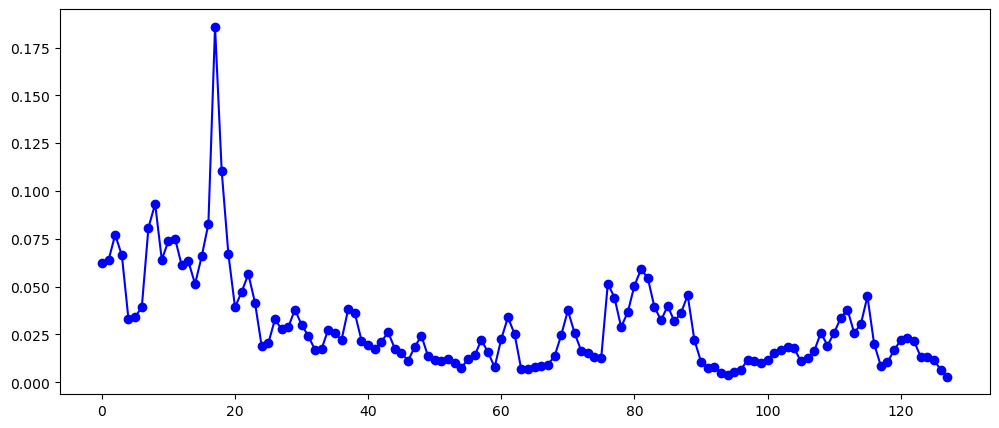

In [16]:
gene_expression.shape
bin_indices = np.arange(len(gene_expression))

plt.figure(figsize=(12, 5))
plt.plot(bin_indices, gene_expression, marker='o', linestyle='-', color='b', label='Gene Expression')

# Add labels and title

In [22]:
prediction['human'].shape

torch.Size([128, 5313])

In [21]:
len(prediction['human'].mean(dim=1).cpu().detach().numpy())

128

In [28]:
sum(prediction['human'].mean(dim=1).cpu().detach().numpy())

np.float32(59.22046)

In [27]:
gene_expression = prediction['human'][:, [100,200]].cpu().detach().numpy()
gene_expression.shape

(128, 2)

In [29]:
sum(prediction['human'][:,tracks].mean(dim=1).cpu().detach().numpy())

np.float32(148.59712)

In [18]:
import pandas as pd
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/0.5/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets.shape  # (5313, 8) 

(5313, 8)

In [25]:
df_targets

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion
3,3,0,ENCFF463ZLQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:Ishikawa treated with 0.02% dimethyl sul...
4,4,0,ENCFF890OGQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:GM03348
...,...,...,...,...,...,...,...,...
5308,5308,0,CNhs14239,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:epithelioid sarcoma cell line:HS-ES-2R
5309,5309,0,CNhs14240,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:squamous cell lung carcinoma cell line:RE...
5310,5310,0,CNhs14241,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:gastric cancer cell line:GSS
5311,5311,0,CNhs14244,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:carcinoid cell line:NCI-H727


In [54]:
gene_expression_mean = prediction['human'].mean(dim=1).cpu().detach().numpy()

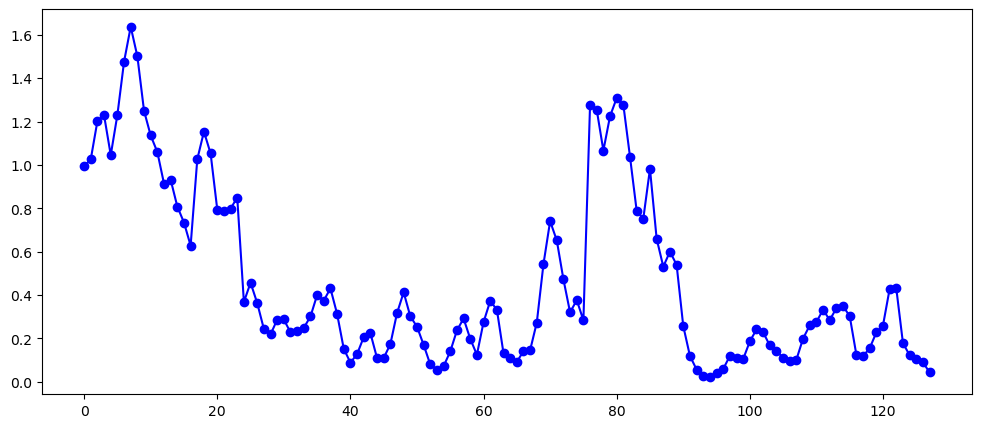

In [55]:
gene_expression_mean.shape
bin_indices = np.arange(len(gene_expression_mean))

plt.figure(figsize=(12, 5))
plt.plot(bin_indices, gene_expression_mean, marker='o', linestyle='-', color='b', label='Gene Expression')

In [59]:
sequence2 = sequence.copy()

In [76]:
sequence2[13] = 1
sequence2[14] = 2
sequence2[15] = 3
 

In [77]:
seq2 = torch.tensor(sequence2)
prediction2 = model(seq2)

In [78]:
gene_expression_mean2 = prediction2['human'].mean(dim=1).cpu().detach().numpy()

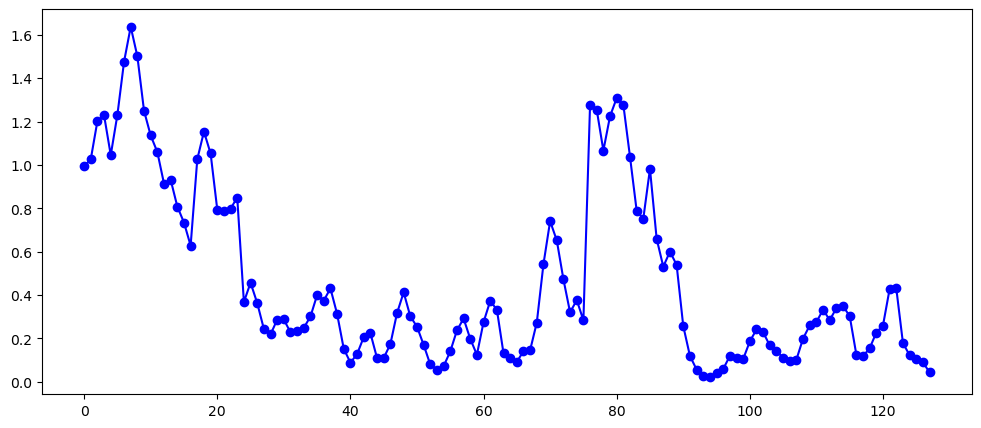

In [79]:
gene_expression_mean2.shape
bin_indices = np.arange(len(gene_expression_mean2))

plt.figure(figsize=(12, 5))
plt.plot(bin_indices, gene_expression_mean2, marker='o', linestyle='-', color='b', label='Gene Expression')

In [80]:
sum(gene_expression_mean2)

np.float32(59.218346)

In [81]:
sum(gene_expression_mean)

np.float32(59.21806)

In [82]:
plink_prefix = '/projects/ps-renlab2/sux002/DSC180/data/ef_md_test_01/DATA/GTEx_v8_genotype_EUR_HM3'
snp_bed = torch.from_numpy(np.load(f"{plink_prefix}.bed.npy"))

In [83]:
snp_bed

tensor([[2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        ...,
        [2., 1., 2.,  ..., 2., 2., 2.],
        [2., 2., 0.,  ..., 2., 1., 1.],
        [2., 2., 1.,  ..., 2., 1., 2.]])

In [87]:
import read_sequence

In [123]:
sequence3 = char_to_num(read_sequence.extract_sequence('/projects/ps-renlab2/sux002/DSC180/data/h38.fa', '1', 5, 5+196608))
sequence3

[4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


In [124]:
seq3 = torch.tensor(sequence3)
prediction3 = model(seq3)

In [126]:
prediction3['human']

tensor([[0.0191, 0.0221, 0.0505,  ..., 0.0018, 0.0129, 0.0095],
        [0.0219, 0.0255, 0.0579,  ..., 0.0021, 0.0121, 0.0102],
        [0.0484, 0.0535, 0.1492,  ..., 0.0030, 0.0193, 0.0198],
        ...,
        [0.0211, 0.0207, 0.0407,  ..., 0.0020, 0.0148, 0.0147],
        [0.0231, 0.0213, 0.0436,  ..., 0.0022, 0.0103, 0.0130],
        [0.0200, 0.0187, 0.0462,  ..., 0.0028, 0.0128, 0.0156]],
       grad_fn=<SoftplusBackward0>)

In [129]:
def make_prediction(sequence):
    seq = torch.tensor(sequence)
    prediction = model(seq)
    return sum(prediction['human'].mean(dim=1).cpu().detach().numpy())


    

In [130]:
make_prediction(seq3)

/tmp/ipykernel_133773/2611378018.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq = torch.tensor(sequence)


np.float32(84.69582)

In [31]:
chromosome_lengths = {
    '1': 248956422, '2': 242193529, '3': 198295559, '4': 190214555,
    '5': 181538259, '6': 170805979, '7': 159345973, '8': 145138636,
    '9': 138394717, '10': 133797422, '11': 135086622, '12': 133275309,
    '13': 114364328, '14': 107043718, '15': 101991189, '16': 90338345,
    '17': 83257441, '18': 80373285, '19': 58617616, '20': 64444167,
    '21': 46709983, '22': 50818468, 'X': 156040895, 'Y': 57227415,
    'MT': 16569
}

# 读取 BIM 文件（假设没有列名）
bim_file_path = "/projects/ps-renlab2/sux002/DSC180/data/ef_md_test_01/DATA/GTEx_v8_genotype_EUR_HM3.bim"  # 请替换为你的 .bim 文件路径
bim_data = pd.read_csv(bim_file_path, delim_whitespace=True, header=None)

# 添加列名
bim_data.columns = ['Chrom', 'SNP', 'GenDist', 'Position', 'Allele1', 'Allele2']

# 确保 Chrom 是字符串（因为 X, Y, MT 也可能出现）
bim_data['Chrom'] = bim_data['Chrom'].astype(str)

# 定义序列长度
sequence_length = 196608

# 计算每个 SNP 的序列范围
def get_sequence_range(chrom, position):
    chrom_length = chromosome_lengths.get(chrom, None)
    if chrom_length is None:
        return None, None  # 处理异常情况
    start = max(1, position - sequence_length // 2)
    end = min(chrom_length, position + sequence_length // 2)
    return start, end

# 应用函数计算 Start 和 End
bim_data[['Start', 'End']] = bim_data.apply(lambda row: get_sequence_range(row['Chrom'], row['Position']), axis=1, result_type="expand")

# 保存结果
output_path = "../../data/snp_sequence_ranges.txt"
bim_data[['Chrom', 'SNP', 'Position', 'Start', 'End','Allele1', 'Allele2']].to_csv(output_path, sep="\t", index=False)


/tmp/ipykernel_702402/1013689450.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  bim_data = pd.read_csv(bim_file_path, delim_whitespace=True, header=None)


In [32]:
range_data = pd.read_csv('../../data/snp_sequence_ranges.txt', delimiter='\t')
range_data.iloc[1]['End'] - range_data.iloc[1]['Start']

np.int64(196608)

In [142]:
import read_sequence

In [143]:
range_data

,Chrom,SNP,Position,Start,End,Allele1,Allele2
0,1,rs3131972,817341,722007,912675,G,A
1,1,rs3131969,818802,723468,914136,G,A
2,1,rs3131967,818954,723620,914288,C,T
3,1,rs1048488,825532,730198,920866,T,C
4,1,rs12562034,833068,737734,928402,A,G
...,...,...,...,...,...,...,...
1034892,22,rs2285395,50739662,50644328,50818468,A,G
1034893,22,rs13056621,50743331,50647997,50818468,G,A
1034894,22,rs3888396,50772964,50677630,50818468,C,T
1034895,22,rs2238837,50774447,50679113,50818468,C,A


In [33]:
import making_prediction
import read_sequence
import pandas as pd

In [34]:
range_data = pd.read_csv('../../data/snp_sequence_ranges.txt', delimiter='\t')
range_data

,Chrom,SNP,Position,Start,End,Allele1,Allele2
0,1,rs3131972,817341,719037,915645,G,A
1,1,rs3131969,818802,720498,917106,G,A
2,1,rs3131967,818954,720650,917258,C,T
3,1,rs1048488,825532,727228,923836,T,C
4,1,rs12562034,833068,734764,931372,A,G
...,...,...,...,...,...,...,...
1034892,22,rs2285395,50739662,50641358,50818468,A,G
1034893,22,rs13056621,50743331,50645027,50818468,G,A
1034894,22,rs3888396,50772964,50674660,50818468,C,T
1034895,22,rs2238837,50774447,50676143,50818468,C,A


In [35]:
a = range_data.iloc[0]
a

Chrom               1
SNP         rs3131972
Position       817341
Start          719037
End            915645
Allele1             G
Allele2             A
Name: 0, dtype: object

In [36]:
seq1, seq2 = read_sequence.modify_sequence(a['Allele1'], a['Allele2'], a['Start'], a['End'], a['Position'], str(a['Chrom']))

In [41]:
difference = making_prediction.make_prediction(seq1) - making_prediction.make_prediction(seq2)

In [42]:
a['difference'] = difference

/tmp/ipykernel_702402/2540881170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['difference'] = difference
/tmp/ipykernel_702402/2540881170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['difference'] = difference


In [29]:
len(seq)

196608

In [30]:
len(seq3)

190668

In [46]:
range_data = range_data[:10]

In [48]:
import pandas as pd
from tqdm import tqdm

# Initialize an empty list to store results
results = []

# Loop through the DataFrame rows using tqdm for progress tracking
for index, row in tqdm(range_data.iterrows(), total=range_data.shape[0], desc="Processing Rows"):
    # Perform your calculation (example: (A * B) + C)
    seq1, seq2 = read_sequence.modify_sequence(row['Allele1'], row['Allele2'], row['Start'], row['End'], row['Position'], str(row['Chrom']))
    difference = making_prediction.make_prediction(seq1) - making_prediction.make_prediction(seq2)
    # Append the result to the list
    results.append(difference)

range_data.loc[:, 'Result'] = results

# Display the updated DataFrame
range_data

Processing Rows: 100%|██████████| 10/10 [02:17<00:00, 13.75s/it]
/tmp/ipykernel_702402/3979287860.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  range_data['Result'] = results


,Chrom,SNP,Position,Start,End,Allele1,Allele2,Result
0,1,rs3131972,817341,719037,915645,G,A,0.238098
1,1,rs3131969,818802,720498,917106,G,A,0.923996
2,1,rs3131967,818954,720650,917258,C,T,0.052292
3,1,rs1048488,825532,727228,923836,T,C,0.484428
4,1,rs12562034,833068,734764,931372,A,G,-0.229912
5,1,rs12124819,841166,742862,939470,G,A,0.434090
6,1,rs4040617,843942,745638,942246,G,A,0.283691
7,1,rs2905036,857100,758796,955404,T,C,0.081917
8,1,rs4970383,903175,804871,1001479,A,C,0.019478
9,1,rs4475691,911428,813124,1009732,T,C,0.884731


In [56]:
range_data[range_data['Chrom'] == 1]

,Chrom,SNP,Position,Start,End,Allele1,Allele2,Result
0,1,rs3131972,817341,719037,915645,G,A,0.238098
1,1,rs3131969,818802,720498,917106,G,A,0.923996
2,1,rs3131967,818954,720650,917258,C,T,0.052292
3,1,rs1048488,825532,727228,923836,T,C,0.484428
4,1,rs12562034,833068,734764,931372,A,G,-0.229912
5,1,rs12124819,841166,742862,939470,G,A,0.434090
6,1,rs4040617,843942,745638,942246,G,A,0.283691
7,1,rs2905036,857100,758796,955404,T,C,0.081917
8,1,rs4970383,903175,804871,1001479,A,C,0.019478
9,1,rs4475691,911428,813124,1009732,T,C,0.884731
